In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pickle
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb
import xgboost as xgb

import eli5
from eli5.sklearn import PermutationImportance

import os
import glob
import optuna

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

### Load files

In [2]:
base_path = "/root/"

dt_train = pd.read_csv(base_path + "train.csv")
dt_test = pd.read_csv(base_path + "test.csv")

In [3]:
extra_data_path = '/root/extra_data/'

### values needed from dt_train before merge

In [4]:
dt_train['구'] = dt_train['시군구'].map(lambda x : x.split()[1])
dt_train['동'] = dt_train['시군구'].map(lambda x : x.split()[2])
# del dt_train['시군구']

dt_test['구'] = dt_test['시군구'].map(lambda x : x.split()[1])
dt_test['동'] = dt_test['시군구'].map(lambda x : x.split()[2])
# del dt_test['시군구']

In [5]:
dt_train = dt_train[dt_train['계약년월']>=201501]
dt_test = dt_test[dt_test['계약년월']>=201501]

In [6]:
dt_train_over2020 = dt_train[dt_train['계약년월']>=202001]

In [7]:
mean_val_by_gu = dt_train_over2020.groupby("구")["target"].mean().sort_values(ascending=False)
mean_val_by_dong = dt_train_over2020.groupby("동")["target"].mean().sort_values(ascending=False)
std_val_by_gu = dt_train_over2020.groupby("구")["target"].std().sort_values(ascending=False)
std_val_by_dong = dt_train_over2020.groupby("동")["target"].std().sort_values(ascending=False)

### Load Table from pickle

In [8]:
# pickle에서 데이터프레임 다시 불러오기
with open('/root/data.pickle', 'rb') as f:
    df = pickle.load(f)

In [9]:
df.columns

Index(['번지', '본번', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '구', '동', '계약년', '계약월', '평균공시가격', '계약일', 'date'],
      dtype='object')

In [10]:
df = df[df['계약년월']>=201501]

### concat to process

In [11]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_train['is_test'] = 0
dt_test['is_test'] = 1

In [12]:
dt = pd.concat([dt_train, dt_test])

In [13]:
dt['is_test'].value_counts()

0    636736
1      9272
Name: is_test, dtype: int64

In [14]:
df['large_std_동'] = df['동']
df.drop(['동'], axis=1, inplace=True)

In [15]:
dt = dt.reset_index()

In [16]:
df['동'] = dt['동']

### 구 동 encoding of df

In [17]:
exp_dongs = ['청담동', '압구정동', '청담동', '삼성동', '도곡동', '반포동', '한남동', '성수동']
df["exp_dongs"] = df["동"].apply(lambda x : 1 if x in exp_dongs else 0)

In [18]:
order1_mean_gu = mean_val_by_gu.index.tolist()
order2_mean_dong = mean_val_by_dong.index.tolist()
order3_std_gu = std_val_by_gu.index.tolist()
order4_std_dong = std_val_by_dong.index.tolist()

# Create a dictionary to map district names to their corresponding label encoded values
gu_mapping1 = {district: label for label, district in enumerate(order1_mean_gu)}
gu_mapping2 = {district: label for label, district in enumerate(order3_std_gu)}
dong_mapping1 = {dong: label for label, dong in enumerate(order2_mean_dong)}
dong_mapping2 = {dong: label for label, dong in enumerate(order4_std_dong)}

df['구_encoded'] = df["구"].map(gu_mapping1)
df['구_std'] = df["구"].map(gu_mapping2)
df['동_encoded'] = df["동"].map(dong_mapping1)
df['동_std'] = df["동"].map(dong_mapping2)

In [19]:
df['yrs_diff'] = df['계약년월'].map(lambda x : x // 100) - df['건축년도']

In [20]:
df['is_public'] = dt["k-전용면적별세대현황(60㎡이하)"].notnull()

### 년도에따라 동, 구별 statistics 추가

In [21]:
# stats = df.groupby(['계약년', '구'])['target'].agg(['std', 'mean', 'max'])
# df = df.join(stats, on=['계약년', '구'], rsuffix='_target')

In [22]:
# df['계약년과구에따른std'] = df['std']
# df['계약년과구에따른mean'] = df['mean']
# df['계약년과구에따른max'] = df['max']
# df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [23]:
# stats = df.groupby(['계약년', '동'])['target'].agg(['std', 'mean', 'max'])
# df = df.join(stats, on=['계약년', '동'], rsuffix='_target')

In [24]:
# df['계약년과동에따른std'] = df['std']
# df['계약년과동에따른mean'] = df['mean']
# df['계약년과동에따른max'] = df['max']
# df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [25]:
# # '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# # '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
# df['계약년과동에따른std'] = df['계약년과동에따른std'].fillna(df['계약년과구에따른std'])
# df['계약년과동에따른mean'] = df['계약년과동에따른mean'].fillna(df['계약년과구에따른mean'])
# df['계약년과동에따른max'] = df['계약년과동에따른max'].fillna(df['계약년과구에따른max'])

In [26]:
# df.drop(['계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'], axis=1, inplace=True)

### yrs_diff 에따른 통계량 추가

In [27]:
stats = df.groupby(['yrs_diff', '구'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['yrs_diff', '구'], rsuffix='_target')

In [28]:
df['yrs_diff와구에따른std'] = df['std']
df['yrs_diff와구에따른mean'] = df['mean']
df['yrs_diff와구에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [29]:
stats = df.groupby(['yrs_diff', '동'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['yrs_diff', '동'], rsuffix='_target')

In [30]:
df['yrs_diff와동에따른std'] = df['std']
df['yrs_diff와동에따른mean'] = df['mean']
df['yrs_diff와동에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)

In [31]:
# '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
df['yrs_diff와동에따른std'] = df['yrs_diff와동에따른std'].fillna(df['yrs_diff와구에따른std'])
df['yrs_diff와동에따른mean'] = df['yrs_diff와동에따른mean'].fillna(df['yrs_diff와구에따른mean'])
df['yrs_diff와동에따른max'] = df['yrs_diff와동에따른max'].fillna(df['yrs_diff와구에따른max'])

In [32]:
df.drop(['yrs_diff와구에따른std', 'yrs_diff와구에따른mean', 'yrs_diff와구에따른max'], axis=1, inplace=True)

In [33]:
df.drop(['동', 'large_std_동', '본번'], axis=1, inplace=True)

### KOSPI 종가 delay

In [34]:
# Use glob to find all files that match the pattern
file_paths = glob.glob(extra_data_path + "/KOSPI_*.csv")

# Initialize an empty list to store the dataframes
dfs = []

# Iterate over the file paths and read each CSV file into a dataframe
for file_path in file_paths:
    kospi_df_yr = pd.read_csv(file_path, encoding="euc-kr")
    dfs.append(kospi_df_yr)

kospi_df = pd.concat(dfs, ignore_index=True)
kospi_df = kospi_df.drop(columns=['시가', '고가', '저가'])

In [35]:
kospi_df.rename(columns={"일자":"date", "종가":"Close"}, inplace=True)
kospi_df["date"] = kospi_df['date'].str.replace('/', '-')
kospi_df["date"] = pd.to_datetime(kospi_df["date"])
kospi_df.sort_values(by='date', ascending=True, inplace=True)

In [36]:
kospi_df["Close_delay120d"] = kospi_df["Close"].shift(120)

In [37]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target',
       'is_test', '구', '계약년', '계약월', '평균공시가격', '계약일', 'date', 'exp_dongs',
       '구_encoded', '구_std', '동_encoded', '동_std', 'yrs_diff', 'is_public',
       'yrs_diff와동에따른std', 'yrs_diff와동에따른mean', 'yrs_diff와동에따른max'],
      dtype='object')

In [38]:
df['date'] = pd.to_datetime(df['계약년'].astype(str) + '-' + df['계약월'].astype(str) + '-' + df['계약일'].astype(str))

In [39]:
df = pd.merge(left=df, right=kospi_df, on='date', how='left')

In [40]:
df.drop(columns=['Close', '대비', '등락률', '거래량', '거래대금', '상장시가총액'], inplace=True)

In [41]:
df["Close_delay120d"] = df["Close_delay120d"].interpolate(method='linear', axis=0)

In [42]:
df['date'] = df['date'].astype(str)

In [43]:
df.drop(['구', '구_std', '동_std', '계약년월', '계약년', '계약월', '계약일'], axis=1, inplace=True)

### 면적당단가 적용

In [44]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', 'target', 'is_test',
       '평균공시가격', 'date', 'exp_dongs', '구_encoded', '동_encoded', 'yrs_diff',
       'is_public', 'yrs_diff와동에따른std', 'yrs_diff와동에따른mean',
       'yrs_diff와동에따른max', 'Close_delay120d'],
      dtype='object')

In [45]:
df['ann_price_per_area'] = df['평균공시가격'] / df['전용면적(㎡)']

In [46]:
df['ann_price_per_area'].isnull().sum()

0

In [47]:
df['target_price_per_area'] = df['target'] / df['전용면적(㎡)']

In [48]:
df['target_price_per_area'].isnull().sum()

9272

In [49]:
# Sort the DataFrame by '도로명', '전용면적', and any relevant time column (if available)
df_sorted = df.sort_values(by=['도로명', '전용면적(㎡)', 'date'], ascending=True)

# Forward fill missing values in 'price_per_area' based on '도로명' and '전용면적'
df['target_price_per_area'] = df_sorted.groupby(['도로명', '전용면적(㎡)'])['target_price_per_area'].ffill()

# If there are any remaining missing values after forward fill, you can backfill them
df['target_price_per_area'] = df['target_price_per_area'].bfill()

In [50]:
df['target_price_per_area'].isnull().sum()

0

In [51]:
df['over_240'] = df['전용면적(㎡)'].apply(lambda x: 1 if x > 240 else 0)

In [52]:
df['over_240'].value_counts()

0    645029
1       979
Name: over_240, dtype: int64

In [53]:
df['maxfl'] = df_sorted.groupby('아파트명')['층'].transform('max')
df['is_maxfl'] = (df['층'] == df['maxfl']).astype(int)

In [54]:
df['is_maxfl'].value_counts()

0    618907
1     27101
Name: is_maxfl, dtype: int64

In [55]:
del df['maxfl']

In [56]:
df['over_27yrs'] = df['yrs_diff'].apply(lambda x: 1 if x > 27 else 0)

In [57]:
df['over_27yrs'].value_counts()

0    526483
1    119525
Name: over_27yrs, dtype: int64

In [64]:
df.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', 'target', 'is_test',
       '평균공시가격', 'date', 'exp_dongs', '구_encoded', '동_encoded', 'yrs_diff',
       'is_public', 'yrs_diff와동에따른std', 'yrs_diff와동에따른mean',
       'yrs_diff와동에따른max', 'Close_delay120d', 'ann_price_per_area',
       'target_price_per_area', 'over_240', 'is_maxfl', 'over_27yrs'],
      dtype='object')

### Feature Engineering

### Train

In [58]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(636736, 23) (9272, 23)


In [59]:
# 변수 삭제 및 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '층', '건축년도', 'target', '평균공시가격', 'exp_dongs', '구_encoded', '동_encoded', 'yrs_diff', 'yrs_diff와동에따른std', 'yrs_diff와동에따른mean', 'yrs_diff와동에따른max', 'Close_delay120d', 'ann_price_per_area', 'target_price_per_area', 'over_240', 'is_maxfl', 'over_27yrs']
범주형 변수: ['번지', '아파트명', '도로명', 'date', 'is_public']


In [60]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 5/5 [00:01<00:00,  2.89it/s]


In [61]:
y_train = df_train['target']
X_train = df_train.drop(['target'], axis=1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [67]:
X_test = df_test.drop(['target'], axis=1)

In [63]:
def objective(trial):
    # Define the hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 1000, 5000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
    }

    # Create the XGBRegressor model with the suggested hyperparameters
    xgboost = xgb.XGBRegressor(**params)

    # Train the model
    xgboost.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        eval_metric='rmse',
        early_stopping_rounds=50,  # Early stopping
        verbose=False
    )
    
    # Compute the validation RMSE
    val_rmse = xgboost.evals_result()['validation_1']['rmse'][-1]
    return val_rmse

def optimize_hyperparameters(X_train, X_val, y_train, y_val, n_trials=20):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Create the final model with the best hyperparameters
    best_model = xgb.XGBRegressor(**best_params)

    # Train the final model with early stopping
    best_model.fit(X_train, y_train,
                   eval_set=[(X_train, y_train), (X_val, y_val)],
                   eval_metric='rmse',
                   early_stopping_rounds=50,
                   verbose=False)

    return best_model

In [65]:
best_model_xgb = optimize_hyperparameters(X_train, X_val, y_train, y_val, n_trials=20)

[I 2024-04-01 20:10:23,452] A new study created in memory with name: no-name-8929bc25-ac20-48a9-a82b-ce0df99a8a7c
[I 2024-04-01 20:11:10,729] Trial 0 finished with value: 2426.4203963101754 and parameters: {'n_estimators': 3443, 'max_depth': 22, 'num_leaves': 199, 'min_child_weight': 7, 'colsample_bytree': 0.8143475103518051, 'subsample': 0.746005876293672, 'reg_alpha': 0.004367477398009086, 'reg_lambda': 0.0015843672693008732}. Best is trial 0 with value: 2426.4203963101754.
[I 2024-04-01 20:12:26,580] Trial 1 finished with value: 2688.242579034519 and parameters: {'n_estimators': 1543, 'max_depth': 29, 'num_leaves': 809, 'min_child_weight': 6, 'colsample_bytree': 0.9505049860856504, 'subsample': 0.9927647736732687, 'reg_alpha': 1.4020368961921354e-08, 'reg_lambda': 2.0859124945599404e-05}. Best is trial 0 with value: 2426.4203963101754.
[I 2024-04-01 20:13:08,058] Trial 2 finished with value: 2663.9497743827346 and parameters: {'n_estimators': 4038, 'max_depth': 26, 'num_leaves': 262

In [68]:
real_test_pred_best = best_model_xgb.predict(X_test)
preds_df = pd.DataFrame(real_test_pred_best.astype(int), columns=["target"])
preds_df.to_csv('gu-dong-encoded_optuna_0402.csv', index=False)

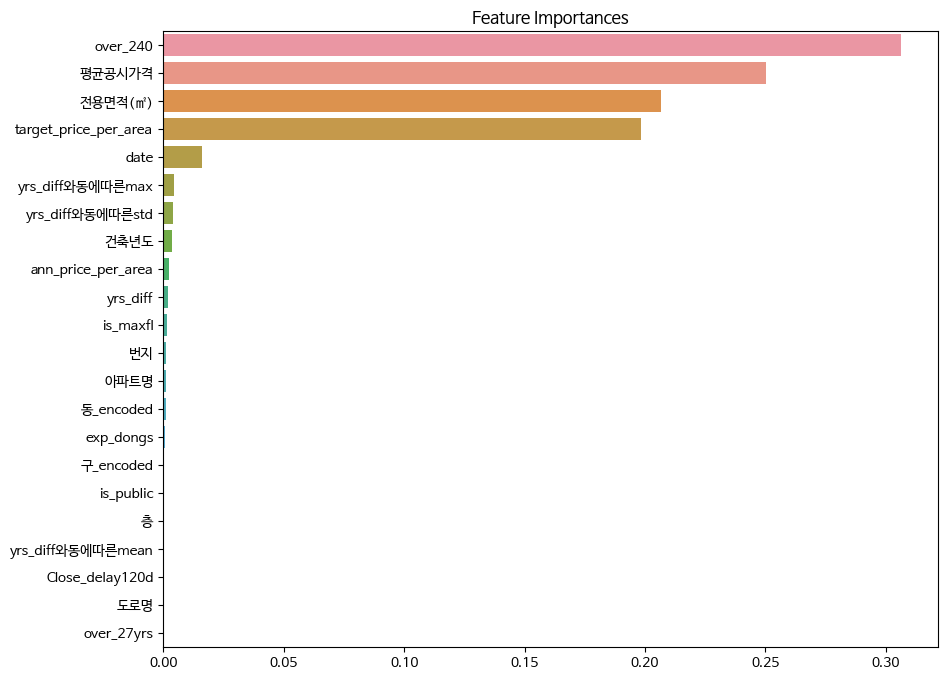

In [69]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model_xgb.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [71]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(best_model_xgb,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
3231151867.0885 ± 14291053.3088,target_price_per_area
1628370798.5316 ± 17752559.0781,전용면적(㎡)
110545756.9487 ± 1519061.1610,평균공시가격
33450319.2059 ± 662566.9351,ann_price_per_area
13830741.3492 ± 809808.5469,date
10893971.5204 ± 247481.2163,yrs_diff와동에따른max
5138565.1992 ± 180389.8299,건축년도
3461389.2752 ± 82911.7528,yrs_diff와동에따른std
1969809.7772 ± 72886.4766,yrs_diff
1801631.3139 ± 195188.4236,아파트명


### lgb optuna

In [73]:
import optuna

def objective_lgb(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 1000, 5000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    num_leaves = trial.suggest_int('num_leaves', 100, 1000)
    min_child_samples = trial.suggest_int('min_child_samples', 50, 500)
    feature_fraction = trial.suggest_float('feature_fraction', 0.5, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)
    lambda_l1 = trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True)  # Increase L1 regularization
    lambda_l2 = trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True)  # Increase L2 regularization

    # Create the LGBMRegressor model with the suggested hyperparameters
    gbm = lgb.LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, num_leaves=num_leaves,
                            min_child_samples=min_child_samples, feature_fraction=feature_fraction,
                            bagging_fraction=bagging_fraction, lambda_l1=lambda_l1, lambda_l2=lambda_l2, verbosity=-1)

    # Train the model
    gbm.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
    
    # Compute the validation RMSE
    val_rmse = gbm.best_score_['valid_1']['rmse']
    return val_rmse

def optimize_hyperparameters_lgb(n_trials=100, early_stopping=50, log_evaluation=100):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective_lgb, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Create the final model with the best hyperparameters
    best_model = lgb.LGBMRegressor(**best_params)

    # Train the final model with early stopping and evaluation logging
    best_model.fit(X_train, y_train,
                   eval_set=[(X_train, y_train), (X_val, y_val)],
                   eval_metric='rmse',
                   callbacks=[lgb.early_stopping(stopping_rounds=early_stopping),
                              lgb.log_evaluation(period=log_evaluation, show_stdv=True)])

    return best_model

In [74]:
best_model_lgb = optimize_hyperparameters_lgb(n_trials=20)

[I 2024-04-01 20:34:21,838] A new study created in memory with name: no-name-f8e54f19-e650-460a-a48e-e45aa44eed1c


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3361.82	training's l2: 1.13018e+07	valid_1's rmse: 3764.93	valid_1's l2: 1.41747e+07
[200]	training's rmse: 2814.38	training's l2: 7.92075e+06	valid_1's rmse: 3278.99	valid_1's l2: 1.07518e+07
[300]	training's rmse: 2550.06	training's l2: 6.50283e+06	valid_1's rmse: 3080.05	valid_1's l2: 9.48669e+06
[400]	training's rmse: 2366.83	training's l2: 5.60189e+06	valid_1's rmse: 2965.95	valid_1's l2: 8.79688e+06
[500]	training's rmse: 2228.59	training's l2: 4.96661e+06	valid_1's rmse: 2876.13	valid_1's l2: 8.2721e+06
[600]	training's rmse: 2120.18	training's l2: 4.49515e+06	valid_1's rmse: 2818.25	valid_1's l2: 7.94252e+06
[700]	training's rmse: 2027.78	training's l2: 4.11188e+06	valid_1's rmse: 2770.37	valid_1's l2: 7.67494e+06
[800]	training's rmse: 1950.08	training's l2: 3.80283e+06	valid_1's rmse: 2732.04	valid_1's l2: 7.46405e+06
[900]	training's rmse: 1882.47	training's l2: 3.54371e+06	valid_1's rmse: 26

[I 2024-04-01 20:35:36,219] Trial 0 finished with value: 2243.8973271999494 and parameters: {'n_estimators': 4855, 'max_depth': 34, 'num_leaves': 252, 'min_child_samples': 406, 'feature_fraction': 0.8088277476317605, 'bagging_fraction': 0.9225418834996411, 'lambda_l1': 0.0040402132627681405, 'lambda_l2': 0.7626214285889906}. Best is trial 0 with value: 2243.8973271999494.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1769.91	training's l2: 3.13259e+06	valid_1's rmse: 2621.56	valid_1's l2: 6.87255e+06
[200]	training's rmse: 1330.63	training's l2: 1.77059e+06	valid_1's rmse: 2384.46	valid_1's l2: 5.68564e+06
[300]	training's rmse: 1098.54	training's l2: 1.20679e+06	valid_1's rmse: 2308.04	valid_1's l2: 5.32704e+06
[400]	training's rmse: 947.89	training's l2: 898495	valid_1's rmse: 2265.88	valid_1's l2: 5.1342e+06
[500]	training's rmse: 835.805	training's l2: 698570	valid_1's rmse: 2239.77	valid_1's l2: 5.01658e+06
[600]	training's rmse: 750.955	training's l2: 563934	valid_1's rmse: 2220.09	valid_1's l2: 4.92878e+06
[700]	training's rmse: 683.888	training's l2: 467703	valid_1's rmse: 2210.32	valid_1's l2: 4.8855e+06
[800]	training's rmse: 626.829	training's l2: 392914	valid_1's rmse: 2204.89	valid_1's l2: 4.86155e+06
[900]	training's rmse: 577.789	training's l2: 333840	valid_1's rmse: 2200.94	valid_1's l2: 4.84412e+06


[I 2024-04-01 20:36:09,581] Trial 1 finished with value: 2185.0968449237903 and parameters: {'n_estimators': 2092, 'max_depth': 44, 'num_leaves': 590, 'min_child_samples': 53, 'feature_fraction': 0.7649443087843137, 'bagging_fraction': 0.9022760152916929, 'lambda_l1': 1.8309782031674767e-08, 'lambda_l2': 0.0008160948969022045}. Best is trial 1 with value: 2185.0968449237903.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3761.29	training's l2: 1.41473e+07	valid_1's rmse: 4220.52	valid_1's l2: 1.78128e+07
[200]	training's rmse: 3155.3	training's l2: 9.95594e+06	valid_1's rmse: 3673.13	valid_1's l2: 1.34919e+07
[300]	training's rmse: 2855.65	training's l2: 8.15472e+06	valid_1's rmse: 3418.54	valid_1's l2: 1.16864e+07
[400]	training's rmse: 2654.84	training's l2: 7.04818e+06	valid_1's rmse: 3240.75	valid_1's l2: 1.05025e+07
[500]	training's rmse: 2511.65	training's l2: 6.30837e+06	valid_1's rmse: 3118.72	valid_1's l2: 9.72639e+06
[600]	training's rmse: 2401.28	training's l2: 5.76614e+06	valid_1's rmse: 3027.86	valid_1's l2: 9.16792e+06
[700]	training's rmse: 2305.08	training's l2: 5.31342e+06	valid_1's rmse: 2947.84	valid_1's l2: 8.68974e+06
[800]	training's rmse: 2228.14	training's l2: 4.96459e+06	valid_1's rmse: 2881.65	valid_1's l2: 8.30392e+06
[900]	training's rmse: 2160.41	training's l2: 4.66738e+06	valid_1's rmse: 28

[I 2024-04-01 20:36:24,578] Trial 2 finished with value: 2646.979554948332 and parameters: {'n_estimators': 1393, 'max_depth': 16, 'num_leaves': 929, 'min_child_samples': 495, 'feature_fraction': 0.8309352482779783, 'bagging_fraction': 0.5421975978597872, 'lambda_l1': 4.833612279554347e-07, 'lambda_l2': 0.3684011510998494}. Best is trial 1 with value: 2185.0968449237903.


Did not meet early stopping. Best iteration is:
[1393]	training's rmse: 1911.64	training's l2: 3.65436e+06	valid_1's rmse: 2646.98	valid_1's l2: 7.0065e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2956.04	training's l2: 8.73815e+06	valid_1's rmse: 3453.95	valid_1's l2: 1.19297e+07
[200]	training's rmse: 2411.45	training's l2: 5.81508e+06	valid_1's rmse: 3026.17	valid_1's l2: 9.15771e+06
[300]	training's rmse: 2139.15	training's l2: 4.57598e+06	valid_1's rmse: 2843.32	valid_1's l2: 8.08446e+06
[400]	training's rmse: 1957.12	training's l2: 3.83034e+06	valid_1's rmse: 2741.93	valid_1's l2: 7.5182e+06
[500]	training's rmse: 1822.77	training's l2: 3.32249e+06	valid_1's rmse: 2668.71	valid_1's l2: 7.12203e+06
[600]	training's rmse: 1715.3	training's l2: 2.94226e+06	valid_1's rmse: 2620.61	valid_1's l2: 6.86761e+06
[700]	training's rmse: 1624.93	training's l2: 2.6404e+06	valid_1's rmse: 2568.56	valid_1's l2: 6.59749e+06
[800]	training's rmse: 1552.59

[I 2024-04-01 20:37:35,054] Trial 3 finished with value: 2289.2325179728255 and parameters: {'n_estimators': 2854, 'max_depth': 30, 'num_leaves': 386, 'min_child_samples': 231, 'feature_fraction': 0.6443645112883487, 'bagging_fraction': 0.8097820343324478, 'lambda_l1': 5.661897396955039e-05, 'lambda_l2': 0.00067419981498425}. Best is trial 1 with value: 2185.0968449237903.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2025.96	training's l2: 4.10451e+06	valid_1's rmse: 2991.17	valid_1's l2: 8.94708e+06
[200]	training's rmse: 1562.6	training's l2: 2.44172e+06	valid_1's rmse: 2691.8	valid_1's l2: 7.24581e+06
[300]	training's rmse: 1325.24	training's l2: 1.75625e+06	valid_1's rmse: 2528.13	valid_1's l2: 6.39146e+06
[400]	training's rmse: 1172.09	training's l2: 1.37381e+06	valid_1's rmse: 2443.46	valid_1's l2: 5.9705e+06
[500]	training's rmse: 1060.15	training's l2: 1.12392e+06	valid_1's rmse: 2378.54	valid_1's l2: 5.65743e+06
[600]	training's rmse: 969.575	training's l2: 940076	valid_1's rmse: 2330.75	valid_1's l2: 5.43238e+06
[700]	training's rmse: 892.468	training's l2: 796500	valid_1's rmse: 2294.88	valid_1's l2: 5.26648e+06
[800]	training's rmse: 828.517	training's l2: 686440	valid_1's rmse: 2266.32	valid_1's l2: 5.13619e+06
[900]	training's rmse: 773.234	training's l2: 597891	valid_1's rmse: 2240.08	valid_1's l2: 5.

[I 2024-04-01 20:38:46,203] Trial 4 finished with value: 2132.720689409604 and parameters: {'n_estimators': 3843, 'max_depth': 48, 'num_leaves': 667, 'min_child_samples': 81, 'feature_fraction': 0.9253992059729856, 'bagging_fraction': 0.7594344727427262, 'lambda_l1': 0.009735218091316326, 'lambda_l2': 0.7835257684924782}. Best is trial 4 with value: 2132.720689409604.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3885.94	training's l2: 1.51005e+07	valid_1's rmse: 4364.71	valid_1's l2: 1.90507e+07
[200]	training's rmse: 3366.72	training's l2: 1.13348e+07	valid_1's rmse: 3879.45	valid_1's l2: 1.50502e+07
[300]	training's rmse: 3075.61	training's l2: 9.45939e+06	valid_1's rmse: 3624.84	valid_1's l2: 1.31395e+07
[400]	training's rmse: 2896.84	training's l2: 8.3917e+06	valid_1's rmse: 3489.27	valid_1's l2: 1.2175e+07
[500]	training's rmse: 2771.67	training's l2: 7.68216e+06	valid_1's rmse: 3397.73	valid_1's l2: 1.15446e+07
[600]	training's rmse: 2667.2	training's l2: 7.11394e+06	valid_1's rmse: 3329.14	valid_1's l2: 1.10832e+07
[700]	training's rmse: 2587.03	training's l2: 6.69275e+06	valid_1's rmse: 3277.62	valid_1's l2: 1.07428e+07
[800]	training's rmse: 2510.05	training's l2: 6.30037e+06	valid_1's rmse: 3231.01	valid_1's l2: 1.04394e+07
[900]	training's rmse: 2449.14	training's l2: 5.99827e+06	valid_1's rmse: 3186

[I 2024-04-01 20:39:00,454] Trial 5 finished with value: 2805.6740094612596 and parameters: {'n_estimators': 2068, 'max_depth': 10, 'num_leaves': 576, 'min_child_samples': 440, 'feature_fraction': 0.9360120633647203, 'bagging_fraction': 0.5981591455613617, 'lambda_l1': 2.8879582410465533e-08, 'lambda_l2': 4.1259479114515666e-05}. Best is trial 4 with value: 2132.720689409604.


Did not meet early stopping. Best iteration is:
[2068]	training's rmse: 1980.92	training's l2: 3.92406e+06	valid_1's rmse: 2805.67	valid_1's l2: 7.87181e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3261.79	training's l2: 1.06393e+07	valid_1's rmse: 3762.44	valid_1's l2: 1.41559e+07
[200]	training's rmse: 2746.15	training's l2: 7.54132e+06	valid_1's rmse: 3302.2	valid_1's l2: 1.09045e+07
[300]	training's rmse: 2495.71	training's l2: 6.22859e+06	valid_1's rmse: 3114.19	valid_1's l2: 9.69817e+06
[400]	training's rmse: 2323.55	training's l2: 5.39889e+06	valid_1's rmse: 3003.06	valid_1's l2: 9.01839e+06
[500]	training's rmse: 2191.82	training's l2: 4.80408e+06	valid_1's rmse: 2932.42	valid_1's l2: 8.59909e+06
[600]	training's rmse: 2079.45	training's l2: 4.32412e+06	valid_1's rmse: 2862.07	valid_1's l2: 8.19147e+06
[700]	training's rmse: 1988.69	training's l2: 3.95488e+06	valid_1's rmse: 2807.62	valid_1's l2: 7.88271e+06
[800]	training's rmse: 1909

[I 2024-04-01 20:40:15,199] Trial 6 finished with value: 2250.2712401875183 and parameters: {'n_estimators': 4435, 'max_depth': 34, 'num_leaves': 751, 'min_child_samples': 370, 'feature_fraction': 0.88272169120811, 'bagging_fraction': 0.9227769602880567, 'lambda_l1': 5.436500178360597e-05, 'lambda_l2': 0.6284045710184755}. Best is trial 4 with value: 2132.720689409604.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3580.81	training's l2: 1.28222e+07	valid_1's rmse: 4043.46	valid_1's l2: 1.63496e+07
[200]	training's rmse: 2866.15	training's l2: 8.21481e+06	valid_1's rmse: 3384.77	valid_1's l2: 1.14567e+07
[300]	training's rmse: 2558.95	training's l2: 6.54821e+06	valid_1's rmse: 3131.05	valid_1's l2: 9.80344e+06
[400]	training's rmse: 2358.22	training's l2: 5.56119e+06	valid_1's rmse: 2986.96	valid_1's l2: 8.92193e+06
[500]	training's rmse: 2218.39	training's l2: 4.92126e+06	valid_1's rmse: 2889.6	valid_1's l2: 8.34981e+06
[600]	training's rmse: 2107.66	training's l2: 4.44221e+06	valid_1's rmse: 2817.97	valid_1's l2: 7.94093e+06
[700]	training's rmse: 2015	training's l2: 4.06023e+06	valid_1's rmse: 2758.54	valid_1's l2: 7.60957e+06
[800]	training's rmse: 1936.99	training's l2: 3.75193e+06	valid_1's rmse: 2713.45	valid_1's l2: 7.36279e+06
[900]	training's rmse: 1871.87	training's l2: 3.50389e+06	valid_1's rmse: 2672.

[I 2024-04-01 20:41:11,355] Trial 7 finished with value: 2283.7628494512237 and parameters: {'n_estimators': 4280, 'max_depth': 19, 'num_leaves': 155, 'min_child_samples': 367, 'feature_fraction': 0.5982976948995056, 'bagging_fraction': 0.7994200044961981, 'lambda_l1': 0.16254295819658432, 'lambda_l2': 5.8375423714268365e-08}. Best is trial 4 with value: 2132.720689409604.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2359.76	training's l2: 5.56846e+06	valid_1's rmse: 3431.15	valid_1's l2: 1.17728e+07
[200]	training's rmse: 1685.98	training's l2: 2.84252e+06	valid_1's rmse: 2967.6	valid_1's l2: 8.80666e+06
[300]	training's rmse: 1363.07	training's l2: 1.85796e+06	valid_1's rmse: 2808.15	valid_1's l2: 7.88573e+06
[400]	training's rmse: 1153.76	training's l2: 1.33117e+06	valid_1's rmse: 2723.17	valid_1's l2: 7.41566e+06
[500]	training's rmse: 1005.41	training's l2: 1.01086e+06	valid_1's rmse: 2668.8	valid_1's l2: 7.12252e+06
[600]	training's rmse: 891.785	training's l2: 795280	valid_1's rmse: 2638.23	valid_1's l2: 6.96025e+06
[700]	training's rmse: 803.022	training's l2: 644844	valid_1's rmse: 2618.44	valid_1's l2: 6.85625e+06
[800]	training's rmse: 731.529	training's l2: 535134	valid_1's rmse: 2604.08	valid_1's l2: 6.78121e+06
[900]	training's rmse: 673.243	training's l2: 453257	valid_1's rmse: 2591.54	valid_1's l2: 6

[I 2024-04-01 20:42:08,269] Trial 8 finished with value: 2559.44967521653 and parameters: {'n_estimators': 1441, 'max_depth': 38, 'num_leaves': 882, 'min_child_samples': 55, 'feature_fraction': 0.5138307561995781, 'bagging_fraction': 0.7410134280663954, 'lambda_l1': 0.00894930401468867, 'lambda_l2': 1.4673461318619563e-08}. Best is trial 4 with value: 2132.720689409604.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3490.07	training's l2: 1.21806e+07	valid_1's rmse: 3923.88	valid_1's l2: 1.53969e+07
[200]	training's rmse: 2928.2	training's l2: 8.57437e+06	valid_1's rmse: 3405.04	valid_1's l2: 1.15943e+07
[300]	training's rmse: 2645.6	training's l2: 6.99919e+06	valid_1's rmse: 3180.75	valid_1's l2: 1.01171e+07
[400]	training's rmse: 2456.66	training's l2: 6.03519e+06	valid_1's rmse: 3052.03	valid_1's l2: 9.31486e+06
[500]	training's rmse: 2321.98	training's l2: 5.39157e+06	valid_1's rmse: 2969	valid_1's l2: 8.81494e+06
[600]	training's rmse: 2212.97	training's l2: 4.89725e+06	valid_1's rmse: 2904.56	valid_1's l2: 8.43649e+06
[700]	training's rmse: 2124.99	training's l2: 4.51558e+06	valid_1's rmse: 2850.98	valid_1's l2: 8.12806e+06
[800]	training's rmse: 2049.85	training's l2: 4.20189e+06	valid_1's rmse: 2807.57	valid_1's l2: 7.88242e+06
[900]	training's rmse: 1985.2	training's l2: 3.941e+06	valid_1's rmse: 2770.92	v

[I 2024-04-01 20:42:54,656] Trial 9 finished with value: 2350.0344144473274 and parameters: {'n_estimators': 3599, 'max_depth': 22, 'num_leaves': 575, 'min_child_samples': 432, 'feature_fraction': 0.6789268435964232, 'bagging_fraction': 0.9641538978349042, 'lambda_l1': 0.20709484608157697, 'lambda_l2': 1.1609739391903448e-08}. Best is trial 4 with value: 2132.720689409604.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2741.71	training's l2: 7.51697e+06	valid_1's rmse: 3638.45	valid_1's l2: 1.32383e+07
[200]	training's rmse: 2193.17	training's l2: 4.81001e+06	valid_1's rmse: 3194.6	valid_1's l2: 1.02055e+07
[300]	training's rmse: 1916.9	training's l2: 3.67452e+06	valid_1's rmse: 2986.44	valid_1's l2: 8.91885e+06
[400]	training's rmse: 1727.65	training's l2: 2.98478e+06	valid_1's rmse: 2848.08	valid_1's l2: 8.11155e+06
[500]	training's rmse: 1590.57	training's l2: 2.52991e+06	valid_1's rmse: 2751.15	valid_1's l2: 7.56883e+06
[600]	training's rmse: 1481.5	training's l2: 2.19483e+06	valid_1's rmse: 2669.68	valid_1's l2: 7.12718e+06
[700]	training's rmse: 1392.38	training's l2: 1.93873e+06	valid_1's rmse: 2606.35	valid_1's l2: 6.79308e+06
[800]	training's rmse: 1319.7	training's l2: 1.74162e+06	valid_1's rmse: 2551.82	valid_1's l2: 6.51176e+06
[900]	training's rmse: 1257.89	training's l2: 1.58228e+06	valid_1's rmse: 2510.

[I 2024-04-01 20:44:38,166] Trial 10 finished with value: 2268.962581723783 and parameters: {'n_estimators': 3493, 'max_depth': 50, 'num_leaves': 711, 'min_child_samples': 175, 'feature_fraction': 0.9728857320089334, 'bagging_fraction': 0.6751442411510373, 'lambda_l1': 0.0010251577950860101, 'lambda_l2': 0.013063425022475103}. Best is trial 4 with value: 2132.720689409604.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1978.44	training's l2: 3.91423e+06	valid_1's rmse: 2848.25	valid_1's l2: 8.11256e+06
[200]	training's rmse: 1495.51	training's l2: 2.23654e+06	valid_1's rmse: 2536.34	valid_1's l2: 6.43302e+06
[300]	training's rmse: 1244.32	training's l2: 1.54833e+06	valid_1's rmse: 2432.12	valid_1's l2: 5.91519e+06
[400]	training's rmse: 1081.91	training's l2: 1.17053e+06	valid_1's rmse: 2374.17	valid_1's l2: 5.63667e+06
[500]	training's rmse: 967.422	training's l2: 935906	valid_1's rmse: 2343.76	valid_1's l2: 5.4932e+06
[600]	training's rmse: 879.174	training's l2: 772947	valid_1's rmse: 2317.86	valid_1's l2: 5.37249e+06
[700]	training's rmse: 809.202	training's l2: 654808	valid_1's rmse: 2301.26	valid_1's l2: 5.29577e+06
[800]	training's rmse: 751.903	training's l2: 565359	valid_1's rmse: 2292.26	valid_1's l2: 5.25446e+06
[900]	training's rmse: 700.04	training's l2: 490056	valid_1's rmse: 2283.58	valid_1's l2: 5.2147

[I 2024-04-01 20:45:14,092] Trial 11 finished with value: 2251.608841704143 and parameters: {'n_estimators': 2335, 'max_depth': 50, 'num_leaves': 426, 'min_child_samples': 55, 'feature_fraction': 0.7383589858008429, 'bagging_fraction': 0.8534078825754174, 'lambda_l1': 5.947897053130978e-07, 'lambda_l2': 8.640654329137724e-06}. Best is trial 4 with value: 2132.720689409604.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2527.08	training's l2: 6.38616e+06	valid_1's rmse: 3432.41	valid_1's l2: 1.17814e+07
[200]	training's rmse: 2009.42	training's l2: 4.03779e+06	valid_1's rmse: 3020.62	valid_1's l2: 9.12415e+06
[300]	training's rmse: 1743.39	training's l2: 3.03942e+06	valid_1's rmse: 2819.61	valid_1's l2: 7.95022e+06
[400]	training's rmse: 1567.17	training's l2: 2.45602e+06	valid_1's rmse: 2693.62	valid_1's l2: 7.2556e+06
[500]	training's rmse: 1433.09	training's l2: 2.05375e+06	valid_1's rmse: 2604.02	valid_1's l2: 6.78091e+06
[600]	training's rmse: 1328.71	training's l2: 1.76546e+06	valid_1's rmse: 2538.69	valid_1's l2: 6.44492e+06
[700]	training's rmse: 1239.33	training's l2: 1.53594e+06	valid_1's rmse: 2490.01	valid_1's l2: 6.20015e+06
[800]	training's rmse: 1167.04	training's l2: 1.36199e+06	valid_1's rmse: 2450.33	valid_1's l2: 6.00411e+06
[900]	training's rmse: 1103.89	training's l2: 1.21857e+06	valid_1's rmse: 24

[I 2024-04-01 20:46:30,061] Trial 12 finished with value: 2205.333214336657 and parameters: {'n_estimators': 2977, 'max_depth': 43, 'num_leaves': 704, 'min_child_samples': 139, 'feature_fraction': 0.9960724367272245, 'bagging_fraction': 0.7310610813804213, 'lambda_l1': 2.3418365637879002e-06, 'lambda_l2': 0.012029009426028553}. Best is trial 4 with value: 2132.720689409604.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2322.61	training's l2: 5.39452e+06	valid_1's rmse: 2848.33	valid_1's l2: 8.11296e+06
[200]	training's rmse: 1854.16	training's l2: 3.43791e+06	valid_1's rmse: 2527.11	valid_1's l2: 6.38631e+06
[300]	training's rmse: 1618.38	training's l2: 2.61916e+06	valid_1's rmse: 2404.11	valid_1's l2: 5.77973e+06
[400]	training's rmse: 1461.96	training's l2: 2.13732e+06	valid_1's rmse: 2337.34	valid_1's l2: 5.46314e+06
[500]	training's rmse: 1345.05	training's l2: 1.80917e+06	valid_1's rmse: 2286.42	valid_1's l2: 5.22774e+06
[600]	training's rmse: 1249.44	training's l2: 1.56109e+06	valid_1's rmse: 2250.43	valid_1's l2: 5.06444e+06
[700]	training's rmse: 1169.38	training's l2: 1.36746e+06	valid_1's rmse: 2220.02	valid_1's l2: 4.92848e+06
[800]	training's rmse: 1100.56	training's l2: 1.21123e+06	valid_1's rmse: 2194.7	valid_1's l2: 4.81673e+06
[900]	training's rmse: 1040.59	training's l2: 1.08283e+06	valid_1's rmse: 21

[I 2024-04-01 20:47:10,779] Trial 13 finished with value: 2110.81218331165 and parameters: {'n_estimators': 1936, 'max_depth': 42, 'num_leaves': 420, 'min_child_samples': 130, 'feature_fraction': 0.7816508687944669, 'bagging_fraction': 0.8684832592837731, 'lambda_l1': 1.3369533674034088e-08, 'lambda_l2': 2.259742345315676e-06}. Best is trial 13 with value: 2110.81218331165.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2413.14	training's l2: 5.82326e+06	valid_1's rmse: 3187.6	valid_1's l2: 1.01608e+07
[200]	training's rmse: 1936.42	training's l2: 3.74972e+06	valid_1's rmse: 2838.9	valid_1's l2: 8.05933e+06
[300]	training's rmse: 1691.97	training's l2: 2.86275e+06	valid_1's rmse: 2663.63	valid_1's l2: 7.0949e+06
[400]	training's rmse: 1520.8	training's l2: 2.31282e+06	valid_1's rmse: 2558.26	valid_1's l2: 6.54472e+06
[500]	training's rmse: 1395.38	training's l2: 1.94708e+06	valid_1's rmse: 2485.94	valid_1's l2: 6.17992e+06
[600]	training's rmse: 1291.48	training's l2: 1.66793e+06	valid_1's rmse: 2432.61	valid_1's l2: 5.91761e+06
[700]	training's rmse: 1205.81	training's l2: 1.45399e+06	valid_1's rmse: 2392.99	valid_1's l2: 5.72642e+06
[800]	training's rmse: 1134.54	training's l2: 1.28718e+06	valid_1's rmse: 2361.97	valid_1's l2: 5.57891e+06
[900]	training's rmse: 1071.84	training's l2: 1.14884e+06	valid_1's rmse: 2332.

[I 2024-04-01 20:48:26,624] Trial 14 finished with value: 2167.0306393306796 and parameters: {'n_estimators': 3705, 'max_depth': 43, 'num_leaves': 429, 'min_child_samples': 136, 'feature_fraction': 0.8981000940292228, 'bagging_fraction': 0.671448873480553, 'lambda_l1': 0.0005808671078296639, 'lambda_l2': 2.380267056154554e-06}. Best is trial 13 with value: 2110.81218331165.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2986.3	training's l2: 8.91798e+06	valid_1's rmse: 3562.54	valid_1's l2: 1.26917e+07
[200]	training's rmse: 2519.55	training's l2: 6.34812e+06	valid_1's rmse: 3147.47	valid_1's l2: 9.90657e+06
[300]	training's rmse: 2283.81	training's l2: 5.21581e+06	valid_1's rmse: 2989.47	valid_1's l2: 8.9369e+06
[400]	training's rmse: 2121.52	training's l2: 4.50084e+06	valid_1's rmse: 2902.3	valid_1's l2: 8.42336e+06
[500]	training's rmse: 1992.91	training's l2: 3.97171e+06	valid_1's rmse: 2827.11	valid_1's l2: 7.99255e+06
[600]	training's rmse: 1886.77	training's l2: 3.55989e+06	valid_1's rmse: 2771.99	valid_1's l2: 7.68395e+06
[700]	training's rmse: 1801.46	training's l2: 3.24526e+06	valid_1's rmse: 2720.14	valid_1's l2: 7.39918e+06
[800]	training's rmse: 1731.4	training's l2: 2.99776e+06	valid_1's rmse: 2682.88	valid_1's l2: 7.19787e+06
[900]	training's rmse: 1666.69	training's l2: 2.77785e+06	valid_1's rmse: 2639	

[I 2024-04-01 20:48:44,162] Trial 15 finished with value: 2562.483293020019 and parameters: {'n_estimators': 1112, 'max_depth': 27, 'num_leaves': 342, 'min_child_samples': 278, 'feature_fraction': 0.8482774401452667, 'bagging_fraction': 0.9957379349382169, 'lambda_l1': 0.019027126141839025, 'lambda_l2': 5.313984102877702e-07}. Best is trial 13 with value: 2110.81218331165.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2279.3	training's l2: 5.19522e+06	valid_1's rmse: 2998.49	valid_1's l2: 8.99095e+06
[200]	training's rmse: 1811.54	training's l2: 3.2817e+06	valid_1's rmse: 2694.81	valid_1's l2: 7.26197e+06
[300]	training's rmse: 1561.3	training's l2: 2.43765e+06	valid_1's rmse: 2559.71	valid_1's l2: 6.55211e+06
[400]	training's rmse: 1392.66	training's l2: 1.9395e+06	valid_1's rmse: 2465.4	valid_1's l2: 6.0782e+06
[500]	training's rmse: 1269.58	training's l2: 1.61184e+06	valid_1's rmse: 2400.98	valid_1's l2: 5.76469e+06
[600]	training's rmse: 1172.66	training's l2: 1.37512e+06	valid_1's rmse: 2360.17	valid_1's l2: 5.57042e+06
[700]	training's rmse: 1092.82	training's l2: 1.19427e+06	valid_1's rmse: 2330.6	valid_1's l2: 5.43168e+06
[800]	training's rmse: 1024.97	training's l2: 1.05057e+06	valid_1's rmse: 2313.66	valid_1's l2: 5.35302e+06
[900]	training's rmse: 967.485	training's l2: 936027	valid_1's rmse: 2295.21	valid

[I 2024-04-01 20:49:52,820] Trial 16 finished with value: 2220.240103164048 and parameters: {'n_estimators': 2478, 'max_depth': 46, 'num_leaves': 802, 'min_child_samples': 121, 'feature_fraction': 0.75220085381307, 'bagging_fraction': 0.848696266247702, 'lambda_l1': 8.599253391482464e-06, 'lambda_l2': 3.3427751320303573e-07}. Best is trial 13 with value: 2110.81218331165.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2990.5	training's l2: 8.94307e+06	valid_1's rmse: 3701.46	valid_1's l2: 1.37008e+07
[200]	training's rmse: 2479.76	training's l2: 6.14923e+06	valid_1's rmse: 3266.09	valid_1's l2: 1.06674e+07
[300]	training's rmse: 2228.62	training's l2: 4.96674e+06	valid_1's rmse: 3099.16	valid_1's l2: 9.60477e+06
[400]	training's rmse: 2052.67	training's l2: 4.21347e+06	valid_1's rmse: 2988.95	valid_1's l2: 8.93385e+06
[500]	training's rmse: 1916.96	training's l2: 3.67472e+06	valid_1's rmse: 2908.99	valid_1's l2: 8.46224e+06
[600]	training's rmse: 1811.27	training's l2: 3.28069e+06	valid_1's rmse: 2851.5	valid_1's l2: 8.13103e+06
[700]	training's rmse: 1712.15	training's l2: 2.93147e+06	valid_1's rmse: 2775.43	valid_1's l2: 7.70301e+06
[800]	training's rmse: 1633.15	training's l2: 2.66718e+06	valid_1's rmse: 2718.66	valid_1's l2: 7.39113e+06
[900]	training's rmse: 1563.19	training's l2: 2.44357e+06	valid_1's rmse: 266

[I 2024-04-01 20:51:17,483] Trial 17 finished with value: 2305.7333617064696 and parameters: {'n_estimators': 4181, 'max_depth': 38, 'num_leaves': 495, 'min_child_samples': 244, 'feature_fraction': 0.9254476293309248, 'bagging_fraction': 0.6584299244988153, 'lambda_l1': 0.5605761657786474, 'lambda_l2': 9.881498953879598e-05}. Best is trial 13 with value: 2110.81218331165.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2990.61	training's l2: 8.94374e+06	valid_1's rmse: 3386.64	valid_1's l2: 1.14693e+07
[200]	training's rmse: 2385.94	training's l2: 5.69269e+06	valid_1's rmse: 2883.67	valid_1's l2: 8.31555e+06
[300]	training's rmse: 2113.49	training's l2: 4.46686e+06	valid_1's rmse: 2704.05	valid_1's l2: 7.31188e+06
[400]	training's rmse: 1936.1	training's l2: 3.74849e+06	valid_1's rmse: 2592.03	valid_1's l2: 6.71862e+06
[500]	training's rmse: 1810.81	training's l2: 3.27902e+06	valid_1's rmse: 2519.03	valid_1's l2: 6.34552e+06
[600]	training's rmse: 1711.7	training's l2: 2.9299e+06	valid_1's rmse: 2462.17	valid_1's l2: 6.06229e+06
[700]	training's rmse: 1630.25	training's l2: 2.65772e+06	valid_1's rmse: 2417.91	valid_1's l2: 5.84629e+06
[800]	training's rmse: 1561.84	training's l2: 2.43933e+06	valid_1's rmse: 2381.99	valid_1's l2: 5.67387e+06
[900]	training's rmse: 1501.73	training's l2: 2.25519e+06	valid_1's rmse: 2356

[I 2024-04-01 20:51:43,334] Trial 18 finished with value: 2168.522972938776 and parameters: {'n_estimators': 3331, 'max_depth': 39, 'num_leaves': 102, 'min_child_samples': 192, 'feature_fraction': 0.6939579806858961, 'bagging_fraction': 0.787065957668437, 'lambda_l1': 0.0004111104440888245, 'lambda_l2': 0.02358479048569745}. Best is trial 13 with value: 2110.81218331165.


Early stopping, best iteration is:
[2726]	training's rmse: 965.51	training's l2: 932209	valid_1's rmse: 2168.52	valid_1's l2: 4.70249e+06
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2863.61	training's l2: 8.20029e+06	valid_1's rmse: 3503.82	valid_1's l2: 1.22767e+07
[200]	training's rmse: 2158.07	training's l2: 4.65726e+06	valid_1's rmse: 2954.44	valid_1's l2: 8.72873e+06
[300]	training's rmse: 1840.68	training's l2: 3.3881e+06	valid_1's rmse: 2748.02	valid_1's l2: 7.5516e+06
[400]	training's rmse: 1641.15	training's l2: 2.69338e+06	valid_1's rmse: 2640.4	valid_1's l2: 6.97171e+06
[500]	training's rmse: 1496.06	training's l2: 2.23821e+06	valid_1's rmse: 2571.99	valid_1's l2: 6.61513e+06
[600]	training's rmse: 1382.52	training's l2: 1.91136e+06	valid_1's rmse: 2526.22	valid_1's l2: 6.38181e+06
[700]	training's rmse: 1292.84	training's l2: 1.67145e+06	valid_1's rmse: 2489.04	valid_1's l2: 6.19531e+06
[800]	training's rmse: 1216.2	training's l2: 1.4

[I 2024-04-01 20:52:10,530] Trial 19 finished with value: 2371.51742281992 and parameters: {'n_estimators': 1755, 'max_depth': 47, 'num_leaves': 277, 'min_child_samples': 104, 'feature_fraction': 0.5551145846102388, 'bagging_fraction': 0.7089095613228861, 'lambda_l1': 0.04256090400411674, 'lambda_l2': 0.0009163882753812722}. Best is trial 13 with value: 2110.81218331165.


[LightGBM] [Warning] feature_fraction is set=0.7816508687944669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7816508687944669
[LightGBM] [Warning] lambda_l2 is set=2.259742345315676e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.259742345315676e-06
[LightGBM] [Warning] lambda_l1 is set=1.3369533674034088e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3369533674034088e-08
[LightGBM] [Warning] bagging_fraction is set=0.8684832592837731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8684832592837731
[LightGBM] [Warning] feature_fraction is set=0.7816508687944669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7816508687944669
[LightGBM] [Warning] lambda_l2 is set=2.259742345315676e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.259742345315676e-06
[LightGBM] [Warning] lambda_l1 is set=1.3369533674034088e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3369

In [79]:
best_model_lgb.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('rmse', 676.7492273041466),
                          ('l2', 457989.5166567596)]),
             'valid_1': OrderedDict([('rmse', 2110.81218331165),
                          ('l2', 4455528.073216895)])})

In [75]:
X_test = df_test.drop(['target'], axis=1)
real_test_pred = best_model_lgb.predict(X_test)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('gu-dong-encoded_optuna_lgb_0402.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.7816508687944669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7816508687944669
[LightGBM] [Warning] lambda_l2 is set=2.259742345315676e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.259742345315676e-06
[LightGBM] [Warning] lambda_l1 is set=1.3369533674034088e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3369533674034088e-08
[LightGBM] [Warning] bagging_fraction is set=0.8684832592837731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8684832592837731


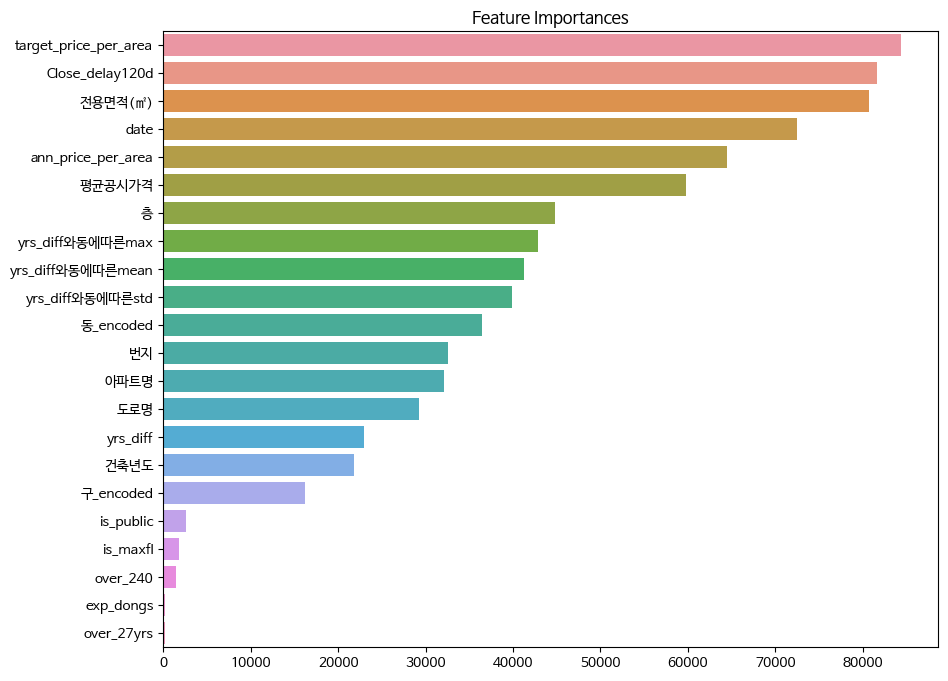

In [76]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model_lgb.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [77]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(best_model_lgb,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

[LightGBM] [Warning] feature_fraction is set=0.7816508687944669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7816508687944669
[LightGBM] [Warning] lambda_l2 is set=2.259742345315676e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.259742345315676e-06
[LightGBM] [Warning] lambda_l1 is set=1.3369533674034088e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3369533674034088e-08
[LightGBM] [Warning] bagging_fraction is set=0.8684832592837731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8684832592837731
[LightGBM] [Warning] feature_fraction is set=0.7816508687944669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7816508687944669
[LightGBM] [Warning] lambda_l2 is set=2.259742345315676e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.259742345315676e-06
[LightGBM] [Warning] lambda_l1 is set=1.3369533674034088e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3369

Weight,Feature
3014436451.8245 ± 24061447.4060,target_price_per_area
1425581355.6098 ± 13408879.9599,전용면적(㎡)
198005000.3952 ± 1589681.3425,평균공시가격
70685116.2913 ± 1374298.1560,ann_price_per_area
14105475.3952 ± 337503.7570,date
11096107.7938 ± 366726.2839,yrs_diff와동에따른max
3627632.3830 ± 322618.8797,구_encoded
2519253.9893 ± 110477.0092,over_240
1042081.3570 ± 83926.5450,yrs_diff와동에따른mean
977078.5636 ± 30081.7334,건축년도


In [78]:
preds_df.describe().round(2)

,target
count,9272.00
mean,107572.68
std,74966.73
min,5200.00
25%,63232.25
50%,89415.50
75%,129632.00
max,1012386.00


In [61]:
# df_train0 = df_train[(df_train['전용면적(㎡)']<60)]
# df_train60 = df_train[(df_train['전용면적(㎡)']>=60)&(df_train['전용면적(㎡)']<135)]
# df_train135 = df_train[(df_train['전용면적(㎡)']>=135)]

In [62]:
X_test = df_test.drop(['target'], axis=1)
# X_test = X_test.drop(columns='Close_delay120d')
# X_test = X_test.drop(columns='계약년월')

# X_test0 = X_test[(X_test['전용면적(㎡)']<60)]
# X_test60 = X_test[(X_test['전용면적(㎡)']>=60)&(X_test['전용면적(㎡)']<135)]
# X_test135 = X_test[(X_test['전용면적(㎡)']>=135)]

In [63]:
# y_train0 = df_train0['target']
# X_train0 = df_train0.drop(['target'], axis=1)


# y_train60 = df_train60['target']
# X_train60 = df_train60.drop(['target'], axis=1)

# y_train135 = df_train135['target']
# X_train135 = df_train135.drop(['target'], axis=1)

In [65]:
# drop_col_under135 = ['target_price_per_area', 'over_240', 'is_maxfl']
# drop_col_over135 = ['ann_price_per_area', 'is_public', 'date']

In [66]:
# X_train0.drop(columns=drop_col_under135, inplace=True)
# X_test0.drop(columns=drop_col_under135, inplace=True)
# X_train60.drop(columns=drop_col_under135, inplace=True)
# X_test60.drop(columns=drop_col_under135, inplace=True)

In [67]:
# # Split the data into train and validation sets
# X_train0, X_val0, y_train0, y_val0 = train_test_split(X_train0, y_train0, test_size=0.2, random_state=2023)
# X_train60, X_val60, y_train60, y_val60 = train_test_split(X_train60, y_train60, test_size=0.2, random_state=2023)

In [70]:
# gbm0 = lgb.LGBMRegressor(n_estimators=5000, max_depth=50, num_leaves=1200, min_child_samples=30,
#                             feature_fraction=0.7,
#                             bagging_fraction=0.9, verbosity=-1)



# gbm60 = lgb.LGBMRegressor(n_estimators=5000, max_depth=50, num_leaves=1200, min_child_samples=30,
#                             feature_fraction=0.7,
#                             bagging_fraction=0.9, verbosity=-1)

In [71]:
# gbm0.fit(
#         X_train0, y_train0, 
#         eval_set=[(X_train0, y_train0), (X_val0, y_val0)], 
#         eval_metric='rmse',
#         callbacks=[lgb.early_stopping(stopping_rounds=50),
#                    lgb.log_evaluation(period=100, show_stdv=True)]
#         )


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2080.32	training's l2: 4.32771e+06	valid_1's rmse: 3547.25	valid_1's l2: 1.2583e+07
[200]	training's rmse: 1574.73	training's l2: 2.47976e+06	valid_1's rmse: 3461.81	valid_1's l2: 1.19841e+07
[300]	training's rmse: 1296.7	training's l2: 1.68143e+06	valid_1's rmse: 3452.84	valid_1's l2: 1.19221e+07
Early stopping, best iteration is:
[285]	training's rmse: 1331.54	training's l2: 1.77299e+06	valid_1's rmse: 3452.22	valid_1's l2: 1.19178e+07


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.7, max_depth=50,
              min_child_samples=30, n_estimators=5000, num_leaves=1200,
              verbosity=-1)

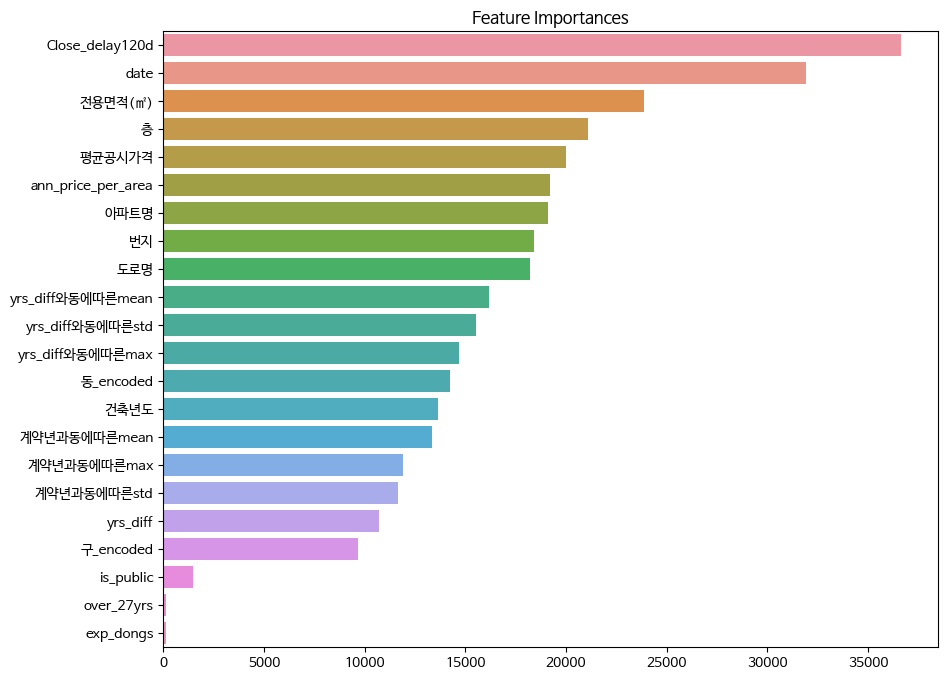

In [72]:
# # 위 feature importance를 시각화해봅니다.
# importances = pd.Series(gbm0.feature_importances_, index=list(X_train0.columns))
# importances = importances.sort_values(ascending=False)

# plt.figure(figsize=(10,8))
# plt.title("Feature Importances")
# sns.barplot(x=importances, y=importances.index)
# plt.show()

In [73]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(gbm0,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring="neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state=42,
                             n_iter=3).fit(X_val0, y_val0)
eli5.show_weights(perm, feature_names=X_val0.columns.tolist())


Weight,Feature
305768149.6477 ± 4312252.9628,date
297109014.3072 ± 3719968.0484,평균공시가격
155057903.2772 ± 1829732.7812,전용면적(㎡)
85978875.6126 ± 1464052.4430,ann_price_per_area
23880666.5684 ± 402059.7724,구_encoded
20096376.7154 ± 152035.4899,건축년도
13271941.4517 ± 443479.4138,계약년과동에따른mean
7946173.9473 ± 62028.7777,yrs_diff
6555222.5758 ± 837190.7462,yrs_diff와동에따른max
5734256.4660 ± 131594.3704,Close_delay120d


In [74]:
gbm60.fit(
        X_train60, y_train60, 
        eval_set=[(X_train60, y_train60), (X_val60, y_val60)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 3825.66	training's l2: 1.46357e+07	valid_1's rmse: 5929.09	valid_1's l2: 3.51541e+07
[200]	training's rmse: 2919.83	training's l2: 8.52542e+06	valid_1's rmse: 5696.91	valid_1's l2: 3.24548e+07
[300]	training's rmse: 2458.78	training's l2: 6.04558e+06	valid_1's rmse: 5652.74	valid_1's l2: 3.19534e+07
[400]	training's rmse: 2131.28	training's l2: 4.54237e+06	valid_1's rmse: 5638.37	valid_1's l2: 3.17912e+07
[500]	training's rmse: 1881.07	training's l2: 3.53841e+06	valid_1's rmse: 5636.79	valid_1's l2: 3.17734e+07
Early stopping, best iteration is:
[491]	training's rmse: 1903.81	training's l2: 3.62451e+06	valid_1's rmse: 5636.06	valid_1's l2: 3.17652e+07


LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.7, max_depth=50,
              min_child_samples=30, n_estimators=5000, num_leaves=1200,
              verbosity=-1)

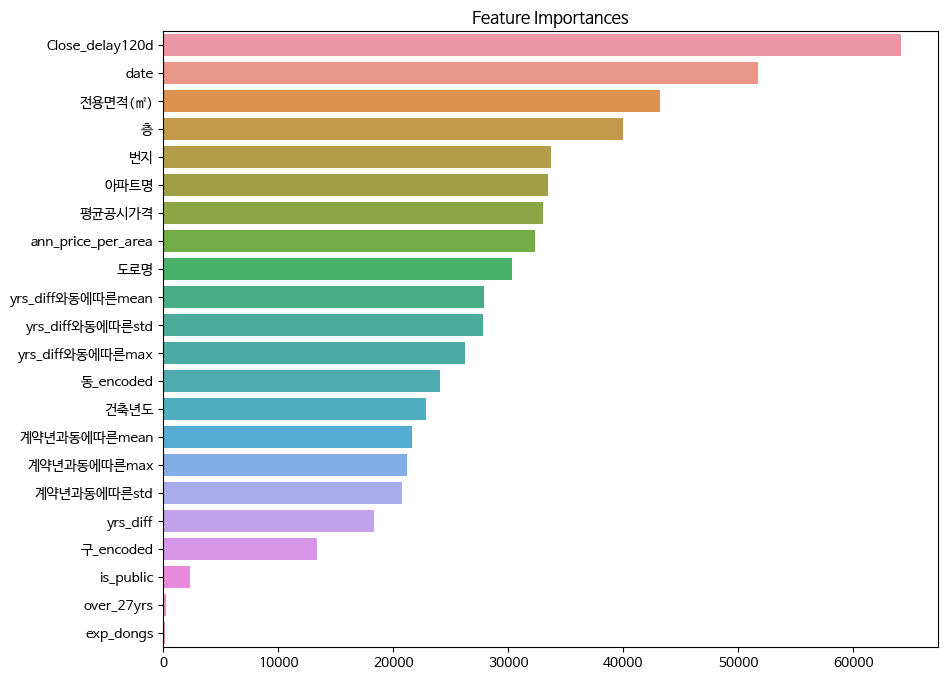

In [75]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm60.feature_importances_, index=list(X_train60.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [76]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(gbm60,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val60, y_val60)
eli5.show_weights(perm, feature_names = X_val60.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
668853892.2105 ± 5023538.2550,date
650889802.2885 ± 5675239.9891,평균공시가격
220968511.5710 ± 4846505.6927,전용면적(㎡)
205303694.0986 ± 1780447.8705,ann_price_per_area
58101012.2108 ± 890743.5180,구_encoded
49627864.4917 ± 511941.3676,건축년도
47471324.7080 ± 2006943.2717,yrs_diff와동에따른max
22191879.0257 ± 219745.4530,계약년과동에따른mean
13392260.4949 ± 511300.6635,yrs_diff와동에따른mean
11896733.0505 ± 57880.7799,도로명


### 135만 다르게 접근해야할 것 같음

In [77]:
print(X_train0.shape, X_val0.shape)
print(X_train60.shape, X_val60.shape)

(196015, 22) (49004, 22)
(291853, 22) (72964, 22)


In [78]:
X_train135.drop(columns=drop_col_over135, inplace=True)

In [79]:
X_test135.drop(columns=drop_col_over135, inplace=True)

In [80]:
X_train135.shape

(26900, 22)

In [81]:
# X_train135, X_val135

In [82]:
from sklearn.model_selection import KFold, cross_val_score

In [83]:
# Define the number of base learners for the ensemble
num_base_learners = 5

# Initialize an empty list to store the base learners
base_learners = []

num_folds = 5
# Define the k-fold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True, random_state=2023)

# Perform k-fold cross-validation
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train135), 1):
    print(f"Fold {fold}/{num_folds}")
    X_train_fold, X_val_fold = X_train135.iloc[train_idx], X_train135.iloc[val_idx]
    y_train_fold, y_val_fold = y_train135.iloc[train_idx], y_train135.iloc[val_idx]
    
    # Initialize a LightGBM regressor for the base learner
    gbm135 = lgb.LGBMRegressor(n_estimators=5000, max_depth=20, num_leaves=600, min_child_samples=10,
                            feature_fraction=0.7, bagging_fraction=0.9, verbosity=-1)
    
    # Train the base learner
    gbm135.fit(
            X_train_fold, y_train_fold, 
            eval_set=[(X_train_fold, y_train_fold), (X_val_fold, y_val_fold)], 
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=50),
                       lgb.log_evaluation(period=100, show_stdv=True)]
            )
    
    # Add the trained base learner to the list
    base_learners.append(gbm135)

# Initialize an empty array to store predictions from each base learner
predictions = np.zeros(len(X_train135))

# Make predictions using each base learner and aggregate them
for gbm in base_learners:
    predictions += gbm.predict(X_train135)

# Take the average of the predictions to get the final prediction
ensemble_prediction = predictions / num_base_learners

Fold 1/5
Training until validation scores don't improve for 50 rounds


[100]	training's rmse: 2059.73	training's l2: 4.24247e+06	valid_1's rmse: 6889.94	valid_1's l2: 4.74712e+07
[200]	training's rmse: 1127.68	training's l2: 1.27167e+06	valid_1's rmse: 6779.63	valid_1's l2: 4.59634e+07
Early stopping, best iteration is:
[233]	training's rmse: 954.666	training's l2: 911388	valid_1's rmse: 6760.18	valid_1's l2: 4.57001e+07
Fold 2/5
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1967.55	training's l2: 3.87124e+06	valid_1's rmse: 8185.4	valid_1's l2: 6.70008e+07
[200]	training's rmse: 1119.78	training's l2: 1.25391e+06	valid_1's rmse: 7955.26	valid_1's l2: 6.32861e+07
[300]	training's rmse: 704.488	training's l2: 496304	valid_1's rmse: 7875.78	valid_1's l2: 6.20279e+07
[400]	training's rmse: 470.922	training's l2: 221768	valid_1's rmse: 7835.04	valid_1's l2: 6.13879e+07
[500]	training's rmse: 328.724	training's l2: 108060	valid_1's rmse: 7810.04	valid_1's l2: 6.09967e+07
[600]	training's rmse: 230.367	training's l2: 53068.

In [84]:
ensemble_prediction.max()

1375701.107908386

In [85]:
real_test_pred0 = gbm0.predict(X_test0)
real_test_pred60 = gbm60.predict(X_test60)

In [86]:
X_test0['target'] = real_test_pred0
X_test60['target'] = real_test_pred60

In [87]:
# List to store predictions from base learners
predictions = []

# Iterate over base learners and get predictions for X_test135
for gbm in base_learners:
    predictions.append(gbm.predict(X_test135))

# Convert predictions to a NumPy array
predictions_array = np.array(predictions)

# Take the maximum prediction across the base learners
max_predictions = np.max(predictions_array, axis=0)

# Fill X_test135['target'] with the maximum predictions
X_test135['target'] = max_predictions


In [88]:
X_test135['target'].describe().round(2)

count        357.00
mean      283165.42
std       160621.86
min        40617.22
25%       174028.02
50%       245654.41
75%       354633.35
max      1181784.75
Name: target, dtype: float64

In [89]:
X_test0.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', '평균공시가격', 'date',
       'exp_dongs', '구_encoded', '동_encoded', 'yrs_diff', 'is_public',
       '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff와동에따른std',
       'yrs_diff와동에따른mean', 'yrs_diff와동에따른max', 'Close_delay120d',
       'ann_price_per_area', 'over_27yrs', 'target'],
      dtype='object')

In [90]:
X_test135.columns

Index(['번지', '아파트명', '전용면적(㎡)', '층', '건축년도', '도로명', '평균공시가격', 'exp_dongs',
       '구_encoded', '동_encoded', 'yrs_diff', '계약년과동에따른std', '계약년과동에따른mean',
       '계약년과동에따른max', 'yrs_diff와동에따른std', 'yrs_diff와동에따른mean',
       'yrs_diff와동에따른max', 'Close_delay120d', 'target_price_per_area',
       'over_240', 'is_maxfl', 'over_27yrs', 'target'],
      dtype='object')

In [91]:
X_test0.drop(['date', 'is_public', 'ann_price_per_area'], axis=1, inplace=True)
X_test60.drop(['date', 'is_public', 'ann_price_per_area'], axis=1, inplace=True)
X_test135.drop(['target_price_per_area', 'over_240', 'is_maxfl'], axis=1, inplace=True)

In [92]:
# concat

concat_test = pd.concat([X_test0, X_test60, X_test135], axis=0)
concat_test = concat_test.sort_index()
concat_test


,번지,아파트명,전용면적(㎡),층,건축년도,도로명,평균공시가격,exp_dongs,구_encoded,동_encoded,yrs_diff,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff와동에따른std,yrs_diff와동에따른mean,yrs_diff와동에따른max,Close_delay120d,over_27yrs,target
636736,4682,319,79.9700,5,1987,6025,120960.000000,0,0,NaN,36,112520.254068,208005.081699,900000.0,78047.338623,180069.893485,540000.0,2449.800000,1,206188.643187
636737,4657,320,108.2017,10,2021,464,155775.000000,0,0,NaN,2,112520.254068,208005.081699,900000.0,103660.430459,169122.259048,1450000.0,2465.100000,0,284885.075476
636738,4658,324,161.0000,15,1984,462,182537.777778,0,0,NaN,39,112520.254068,208005.081699,900000.0,88521.744758,209776.336634,595000.0,2480.400000,1,368122.867929
636739,4658,324,133.4600,14,1984,462,182537.777778,0,0,NaN,39,112520.254068,208005.081699,900000.0,88521.744758,209776.336634,595000.0,2475.480000,1,298672.733761
636740,4658,324,104.4300,6,1984,462,182537.777778,0,0,NaN,39,112520.254068,208005.081699,900000.0,88521.744758,209776.336634,595000.0,2439.090000,1,229733.115630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646003,5716,3617,84.6500,13,2014,5423,39021.326676,0,22,NaN,9,27142.558383,56865.823529,185000.0,22509.608301,41454.276316,208000.0,2428.570000,0,70926.936248
646004,5716,3617,84.6200,12,2014,5423,39021.326676,0,22,NaN,9,27142.558383,56865.823529,185000.0,22509.608301,41454.276316,208000.0,2425.080000,0,70550.706011
646005,5716,3617,101.6500,12,2014,5423,39021.326676,0,22,NaN,9,27142.558383,56865.823529,185000.0,22509.608301,41454.276316,208000.0,2420.253333,0,84510.626167
646006,5716,3617,84.9400,18,2014,5423,39021.326676,0,22,NaN,9,27142.558383,56865.823529,185000.0,22509.608301,41454.276316,208000.0,2415.426667,0,67802.547816


In [93]:

# X_test에서 target만 분리.

ttt = concat_test.loc[:,'target']
ttt = pd.DataFrame(ttt)

ttt= ttt.reset_index()

preds_df= ttt.drop(columns='index')
preds_df= ttt.drop(columns='index')

preds_df2 = pd.DataFrame(preds_df['target'].astype(int), columns=["target"])
preds_df2

preds_df2.to_csv('gu-dong-encoded_0401_5pm_yoon.csv', index=False)



In [94]:
preds_df2.describe().round(2)

,target
count,9272.00
mean,106532.15
std,74050.83
min,9159.00
25%,62842.25
50%,88339.00
75%,125181.50
max,1181784.00
